# 03. 타격점 세기 시각화 (점 크기 = 세기)

In [ ]:
import sys
import os

# 프로젝트 루트: cwd 상위로 올라가며 audio_engine + web 있는 디렉터리 (노트북 위치 무관)
def find_project_root():
    cwd = os.path.abspath(os.getcwd())
    while cwd:
        if os.path.isdir(os.path.join(cwd, 'audio_engine')) and os.path.isdir(os.path.join(cwd, 'web')):
            return cwd
        cwd = os.path.dirname(cwd)
    return os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '..', '..'))  # fallback
project_root = find_project_root()
sys.path.insert(0, project_root)

import librosa
import matplotlib.pyplot as plt
import numpy as np

# 한글 폰트 설정 (macOS 기본 폰트 사용)
plt.rcParams['font.family'] = ['AppleGothic', 'Apple SD Gothic Neo', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

print(f"프로젝트 루트: {project_root}")
print(f"Librosa 버전: {librosa.__version__}")

프로젝트 루트: /Users/laxogud/MADCAMP/W4/music-anaylzer
Librosa 버전: 0.11.0


In [13]:
# 입력: 원본 또는 드럼 스템 경로 (하나만 사용)
# 원본 예: sample_ropes_short.mp3, sample_cardmani.mp3
# 드럼 스템 예: .../stems/htdemucs/sample_ropes_short/drums.wav
# audio_path = os.path.join(project_root, 'audio_engine', 'samples', 'sample_ropes_short.mp3')
audio_path = os.path.join(project_root, 'audio_engine', 'samples', 'stems', 'htdemucs', 'sample_ropes_short', 'drums.wav')

if os.path.exists(audio_path):
    y, sr = librosa.load(audio_path)
    duration = len(y) / sr
    print(f"파일: {os.path.basename(audio_path)}")
    print(f"샘플링 레이트: {sr} Hz, 길이: {duration:.2f} 초")
else:
    raise FileNotFoundError(f"파일을 찾을 수 없습니다: {audio_path}")

파일: drums.wav
샘플링 레이트: 22050 Hz, 길이: 31.11 초


In [18]:
# Onset 검출 + 각 타격점의 세기(onset strength) 추출
hop_length = 256

onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
onset_frames = librosa.onset.onset_detect(
    onset_envelope=onset_env, sr=sr, hop_length=hop_length,
    delta=0.07, wait=4, backtrack=True,
)
onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length)
strengths = onset_env[onset_frames]

print(f"검출된 타격점 수: {len(onset_times)}")
print(f"세기 범위: {strengths.min():.4f} ~ {strengths.max():.4f}")

검출된 타격점 수: 126
세기 범위: 0.0000 ~ 2.2648


질감(Hz) — min: 639.4, max: 6245.7, mean: 2931.4


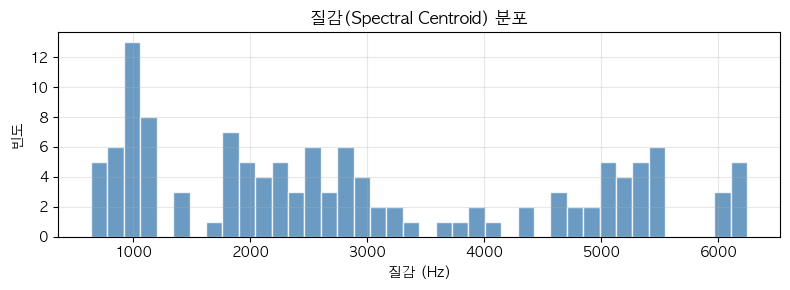

In [19]:
# 질감(Texture) 정의: Spectral Centroid (스펙트럼 중심주파수, Hz) — 밝기
# 동일 hop_length로 프레임별 계산 후 onset 프레임만 인덱싱
centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)
textures = centroid[0, onset_frames]  # 각 타격점의 질감 (Hz)

# Evaluation: 통계
print(f"질감(Hz) — min: {textures.min():.1f}, max: {textures.max():.1f}, mean: {textures.mean():.1f}")

# 질감 분포 히스토그램 (킥 vs 하이햇 등 구분 확인)
fig_hist, ax_hist = plt.subplots(1, 1, figsize=(8, 3))
ax_hist.hist(textures, bins=40, color='steelblue', alpha=0.8, edgecolor='white')
ax_hist.set_title('질감(Spectral Centroid) 분포', fontsize=12, fontweight='bold')
ax_hist.set_xlabel('질감 (Hz)')
ax_hist.set_ylabel('빈도')
ax_hist.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [22]:
# 웹 시각화용 JSON 출력 (events: t, strength, texture, layer, color 포함)
import json

# 세기 → 0~1 정규화 (웹 strength 필드)
s_min, s_max = strengths.min(), strengths.max()
if s_max > s_min:
    strength_norm = ((strengths - s_min) / (s_max - s_min)).tolist()
else:
    strength_norm = [0.7] * len(onset_times)

# 질감(텍스처) → 0~1 정규화 (웹에서 색/레이어 등에 활용 가능)
tex_min, tex_max = float(textures.min()), float(textures.max())
if tex_max > tex_min:
    texture_norm = ((textures - tex_min) / (tex_max - tex_min)).tolist()
else:
    texture_norm = [0.5] * len(onset_times)

events = []
for i, t in enumerate(onset_times):
    events.append({
        "t": round(float(t), 4),
        "strength": round(strength_norm[i], 4),
        "texture": round(texture_norm[i], 4),
        "texture_hz": round(float(textures[i]), 1),
        "layer": "onset",
        "color": "#5a9fd4",
    })

out_dir = os.path.join(project_root, 'audio_engine', 'samples')
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "onset_events.json")
payload = {
    "source": os.path.basename(audio_path),
    "sr": sr,
    "duration_sec": round(duration, 2),
    "texture_min_hz": round(tex_min, 1),
    "texture_max_hz": round(tex_max, 1),
    "events": events,
}
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(payload, f, ensure_ascii=False, indent=2)

print(f"저장: {out_path} (events {len(events)}개, strength·texture 포함, 웹에서 시각화 가능)")

저장: /Users/laxogud/MADCAMP/W4/music-anaylzer/audio_engine/samples/onset_events.json (events 126개, strength·texture 포함, 웹에서 시각화 가능)


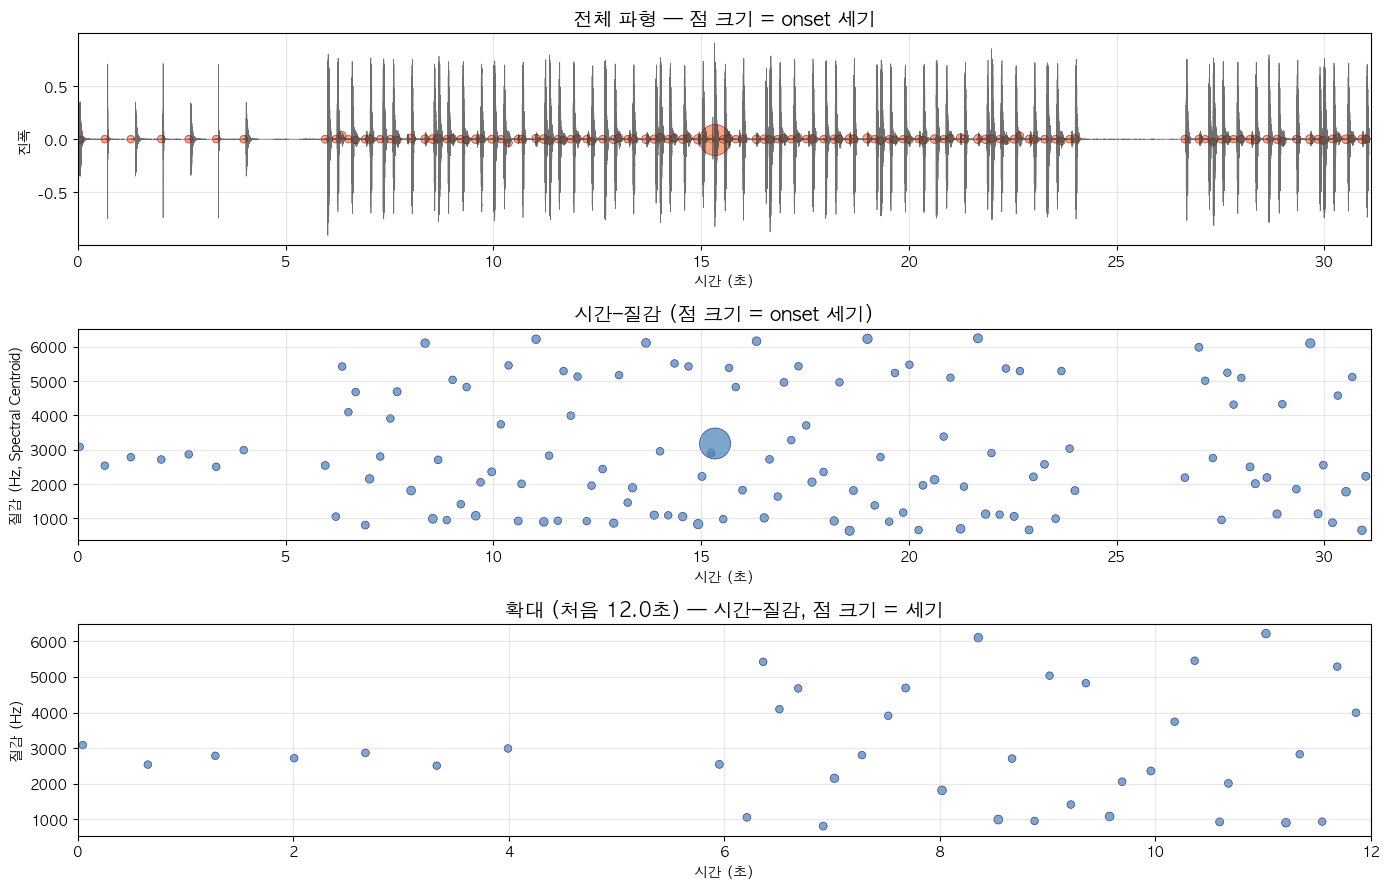

In [23]:
# 시각화: 세기 = 점 크기 유지, y축 = 질감(Hz)
time = np.linspace(0, duration, len(y))
onset_sample_idx = np.clip((onset_times * sr).astype(int), 0, len(y) - 1)
y_at_onset = y[onset_sample_idx]

# 세기 → 점 크기 (선형 스케일, 예: 30 ~ 500)
s_low, s_high = 30, 500
strengths_min, strengths_max = strengths.min(), strengths.max()
if strengths_max > strengths_min:
    s_scaled = (strengths - strengths_min) / (strengths_max - strengths_min) * (s_high - s_low) + s_low
else:
    s_scaled = np.full_like(strengths, (s_low + s_high) / 2)

zoom_duration = min(12.0, duration)
mask_zoom = onset_times < zoom_duration
t_zoom = onset_times[mask_zoom]
textures_zoom = textures[mask_zoom]
s_zoom = s_scaled[mask_zoom]
zoom_samples = int(zoom_duration * sr)
time_zoom = time[:zoom_samples]

fig, axes = plt.subplots(3, 1, figsize=(14, 9))

# Subplot 1: 전체 구간 — 파형 + scatter (점 크기 = 세기)
ax0 = axes[0]
ax0.plot(time, y, linewidth=0.5, alpha=0.7, color='#333')
ax0.scatter(onset_times, y_at_onset, s=s_scaled, alpha=0.7, c='coral', edgecolors='darkred', linewidths=0.5)
ax0.set_title('전체 파형 — 점 크기 = onset 세기', fontsize=14, fontweight='bold')
ax0.set_xlabel('시간 (초)')
ax0.set_ylabel('진폭')
ax0.set_xlim(0, duration)
ax0.grid(True, alpha=0.3)

# Subplot 2: 전체 구간 — 시간–질감 (y축 = 질감 Hz, 점 크기 = 세기)
ax1 = axes[1]
ax1.scatter(onset_times, textures, s=s_scaled, alpha=0.7, c='steelblue', edgecolors='navy', linewidths=0.5)
ax1.set_title('시간–질감 (점 크기 = onset 세기)', fontsize=14, fontweight='bold')
ax1.set_xlabel('시간 (초)')
ax1.set_ylabel('질감 (Hz, Spectral Centroid)')
ax1.set_xlim(0, duration)
ax1.grid(True, alpha=0.3)

# Subplot 3: 확대 구간 — 시간–질감 (동일)
ax2 = axes[2]
ax2.scatter(t_zoom, textures_zoom, s=s_zoom, alpha=0.7, c='steelblue', edgecolors='navy', linewidths=0.5)
ax2.set_title(f'확대 (처음 {zoom_duration:.1f}초) — 시간–질감, 점 크기 = 세기', fontsize=14, fontweight='bold')
ax2.set_xlabel('시간 (초)')
ax2.set_ylabel('질감 (Hz)')
ax2.set_xlim(0, zoom_duration)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()